In [18]:
client_id = 'LcBmKREHsLEFmoBkh1oC'
client_secret =  'hMjvGHFhkb'
url = 'https://openapi.naver.com/v1/search/news.xml'

In [19]:
# 네이버 검색 API 예제 - 블로그 검색
import os
import sys
import urllib.request
# client_id = "LcBmKREHsLEFmoBkh1oC"
# client_secret = "hMjvGHFhkb"
# encText = urllib.parse.quote("강남")
# url_ = "https://openapi.naver.com/v1/search/news"
# display = 100  # 최대 100
# start = 1      # 최대 1000
# sort = 'sim'   # date, sim
# for start in range(1,10):    
#   url = f"{url_}?query={encText}&display={display}&start={start}&sort={sort}"
#   # url = "https://openapi.naver.com/v1/search/news?query=" + encText+"&display=100" # JSON 결과
#   # url = "https://openapi.naver.com/v1/search/blog.xml?query=" + encText # XML 결과  
#   request = urllib.request.Request(url)
#   request.add_header("X-Naver-Client-Id",client_id)
#   request.add_header("X-Naver-Client-Secret",client_secret)
#   with urllib.request.urlopen(request) as response:
#     rescode = response.getcode()
#     if(rescode==200):
#         response_body = response.read()
#         # print(response_body.decode('utf-8'))
#     else:
#         print("Error Code:" + rescode)

In [20]:
# import json
# datas = json.loads(response_body.decode('utf-8'))
# datas['items']
# # len(datas['items'])

In [21]:
#  네이버 뉴스 api 크롤링
# 뉴스 기사를 크롤링해서 리스트로 저장
# 위의 코드를 함수형태로 만들어서.. 사용자로부터 검색어를 입력받아서 수행
# 위의 코드는 한페이지에 100건 을 출력하는 프로그램이고 이걸 수정해서 1 페이지부너 1000페이지까지 각 페이지당 100건씩 수집
# 정렬은 기본과 sim 두가지 다 사용가능 하도록 함수화 ...
# 이렇게 수집한 기사(description) 는 일단... 공백을 기준으로 단어화 하고... 단어를 카운팅
import string
string.punctuation   # !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~
# 단어중에 특수기호는 제거하고 수집한다.
# 수집한 기사 목록을 판다스로 변경하고 csv 로 저장  item 목록에 있는 4개 항목 을 컬럼으로 해서 저장
# 적절한 시각화. (예를들어 단어 와 빈도수)

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [22]:
# 함수로 다시 표현.....................
import json
def naverCrawling(encText,kind = 'news',display=100,start=1,sort='sim'):
  client_id = "LcBmKREHsLEFmoBkh1oC"
  client_secret = "hMjvGHFhkb"
  encText = urllib.parse.quote(encText)
  url_ = f"https://openapi.naver.com/v1/search/{kind}"      
  url = f"{url_}?query={encText}&display={display}&start={start}&sort={sort}"  

  request = urllib.request.Request(url)
  request.add_header("X-Naver-Client-Id",client_id)
  request.add_header("X-Naver-Client-Secret",client_secret)
  with urllib.request.urlopen(request) as response:
    rescode = response.getcode()
    if(rescode==200):
        response_body = response.read()
        datas = json.loads(response_body.decode('utf-8'))
        return datas['items']
    else:
        print("Error Code:" + rescode)

In [23]:
from tqdm import tqdm
encText = input("검색어 : ")
title_list, originallink_list,link_list, desription_list =[],[],[],[]

for start in tqdm(range(1,1001)):
  for data in naverCrawling(encText):
    title_list.append( data['title'])
    originallink_list.append(data['originallink'])
    link_list.append(data['link'])
    desription_list.append(data['description']) 
    

검색어 : 인공지능


100%|██████████| 1000/1000 [18:34<00:00,  1.11s/it]


In [24]:
from functools import reduce
# 데이터 프레임 생성
import pandas as pd
import numpy as np
import string 
puch = string.punctuation
df2 = pd.DataFrame({'title':title_list, 'orignal':originallink_list,'link':link_list, 'desc':desription_list})
temp = df2['title'].apply(lambda x: x.split())
temp = [ i for i in temp.values]
temp = reduce(lambda x,y : x+y, temp)  # 단일 리스트 형태로 변경

In [25]:
import re
def cleanWorld(word):
  # 한글 정규표현식 패턴
  hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
  return "".join([ hangul.sub('', i) for i in word if i not in puch ])

In [26]:
from collections import Counter
word_list_cnt =  Counter( [ i for i in map(cleanWorld, temp) if len(i) > 1] )
# word_list_cnt = dict(word_list_cnt)
word_list_cnt = sorted(word_list_cnt.items(), key = lambda x : x[1],reverse=True)

In [27]:
# top 20 
new_world_list = word_list_cnt[1:22]
new_world_list

[('기술', 16000),
 ('개발', 15000),
 ('기반', 10000),
 ('미래', 8000),
 ('대화형', 7000),
 ('교육자료', 7000),
 ('개발보급', 7000),
 ('나선다', 7000),
 ('활용', 6000),
 ('대구동산병원', 6000),
 ('도입', 6000),
 ('전남교육청', 5000),
 ('안내서', 5000),
 ('중앙대', 5000),
 ('치매', 5000),
 ('최첨단', 5000),
 ('인공지능기반', 5000),
 ('계명대', 5000),
 ('인재와', 5000),
 ('키움증권', 5000),
 ('영웅전', 5000)]

In [28]:
# 한글 처리
# 코렙 한글
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [29]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

<Axes: xlabel='0', ylabel='1'>

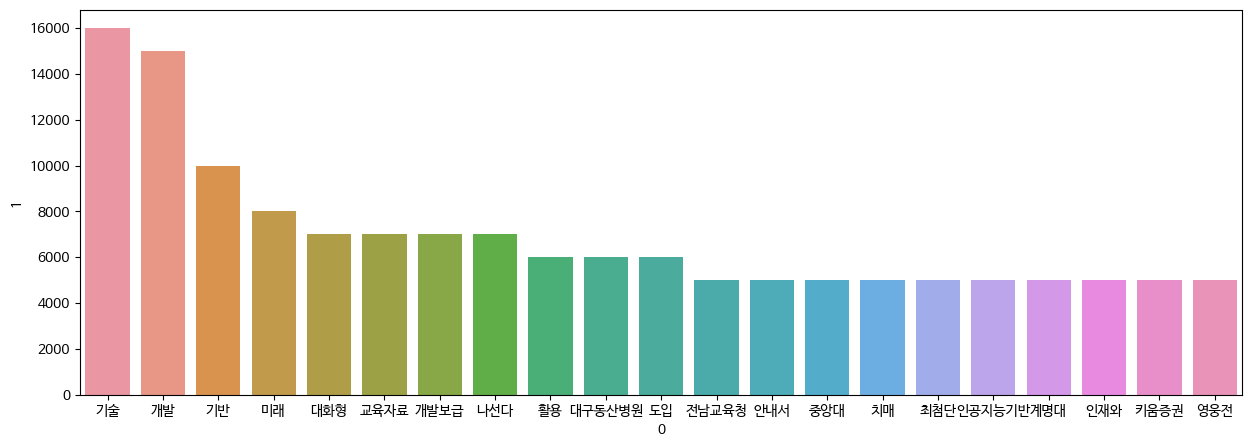

In [30]:
# bar 그래프로 시각화
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
pd.DataFrame(new_world_list)
sns.barplot(data= pd.DataFrame(new_world_list), x= 0, y=1) 

In [ ]:
word_list_cnt[1:]

In [32]:
# Word Cloud
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


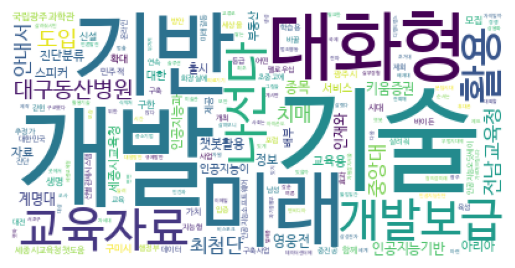

In [39]:
from wordcloud import WordCloud
wc = WordCloud(background_color='white', font_path = "NanumBarunGothic")
cloud = wc.generate_from_frequencies(dict(word_list_cnt[1:]))
plt.imshow(cloud)
plt.axis('off')
plt.show()
cloud.to_file('./navercloud.jpg')

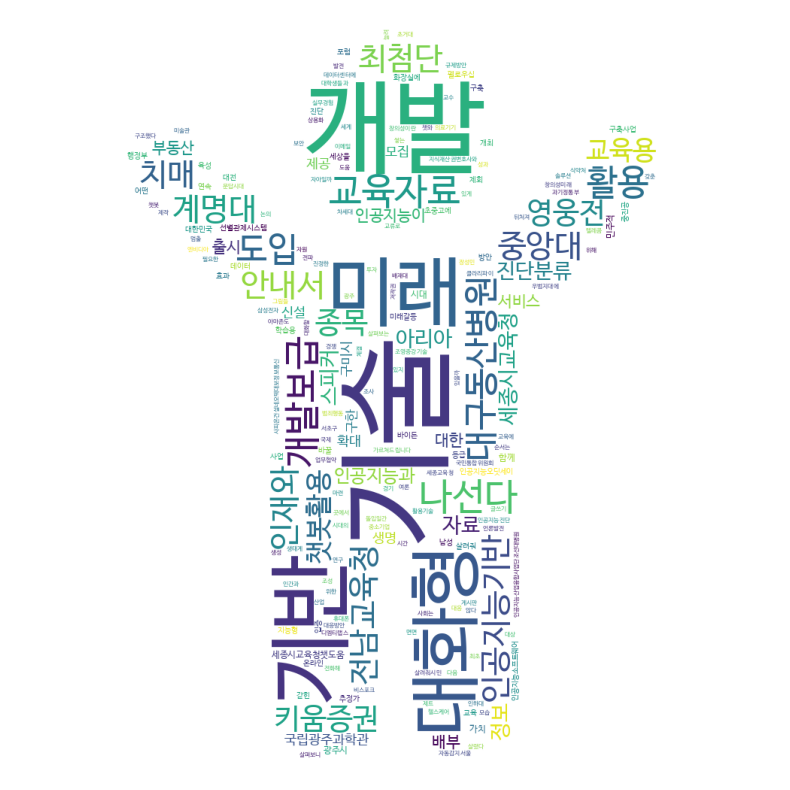

In [45]:
# 이미지는 여기 참고해서 https://www.wordclouds.com/
from PIL import Image
plt.figure(figsize = (10,10))
mask = np.array(Image.open('/content/다운로드.png'))
wc = WordCloud(background_color='white', font_path = "NanumBarunGothic", mask=mask)
cloud = wc.generate_from_frequencies(dict(word_list_cnt[1:]))
plt.imshow(cloud)
plt.axis('off')
plt.show()
cloud.to_file('./navercloud_mask.jpg')